###  UPDATE 1
#### · Replace test data with values from structure subset
#### · Replace conditional entropy with posterior posibility
#### · Simulation with data suggested (Still could not figure with feature importance)
#### · Impute empty leaves value
#### · Roughly compare with permutation based methods


###  UPDATE 2
#### · Replace test data with honest subset
#### · Replace np.abs with something else(undecided)

In [1]:
import sys
import time
import numpy as np
import math
import pandas as pd
from sklearn.utils.validation import check_X_y
from honest_forests.estimators import HonestTreeClassifier
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.validation import check_X_y
from sklearn.utils.multiclass import check_classification_targets
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

In [2]:
##Simulation Data 
#https://nbviewer.org/github/rflperry/math_tutorials/blob/master/tutorials/StatPatternRecognition/Trunk.ipynb

def simulate2(n, d):
    n1 = np.random.binomial(n, 0.5)
    n2 = n - n1
    mu = 1 / np.sqrt(np.arange(1, d+1))
    
    X = np.vstack((
        np.random.normal(mu, 1, (n1, d)),
        np.random.normal(-mu, 1,  (n2, d))
    ))
    
    return X, np.asarray([1]*n1 + [0]*n2)


In [3]:
def Posterior_After(X,v,n_sample):
    
    #Duplicate the sigle sample test
    X_testsample_duplicated = np.tile(X,(n_sample,1))
    
    ### Replace test data with values from structure subset   
    X_variable = np.random.choice(X_structure[:,v],size = n_sample, replace=True)
    
    X_testsample_duplicated[:,v] = X_variable
    X_testsample_duplicated = X_testsample_duplicated.astype(np.float32)
    
    #Obtain the possible leaves with ignoring variable v
    leaves_indicies = np.unique(clf.tree_.apply(X_testsample_duplicated)) 
    value_leaves = np.sum(clf.tree_.value[leaves_indicies], axis=0)
    
    #Calculate the posterior probability for sample x
    
    posterior_proba = value_leaves/np.sum(value_leaves) 
    
    
    return value_leaves,posterior_proba
    
    

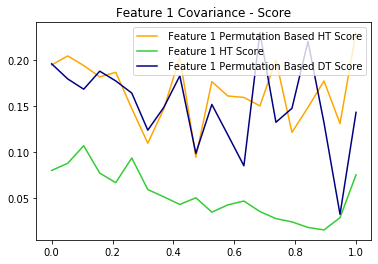

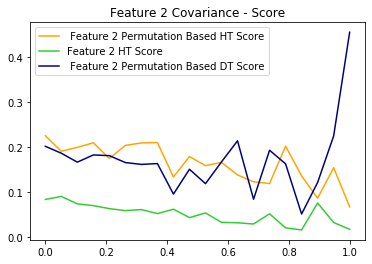

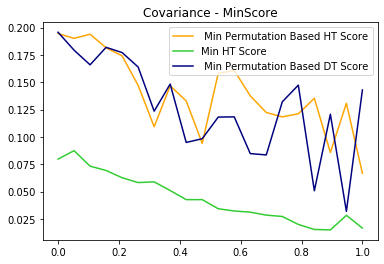

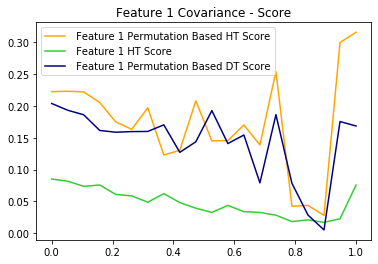

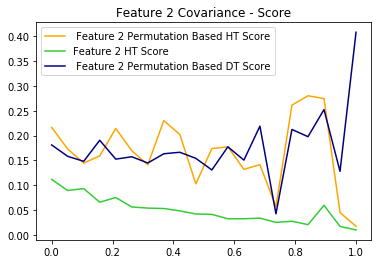

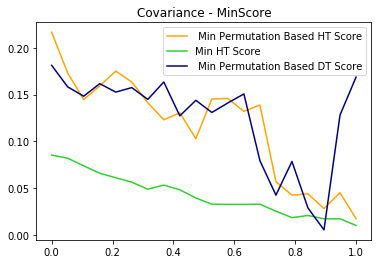

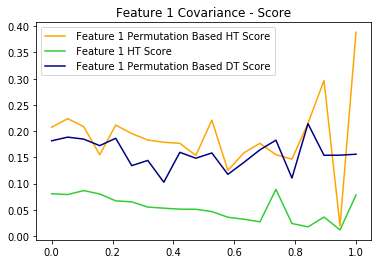

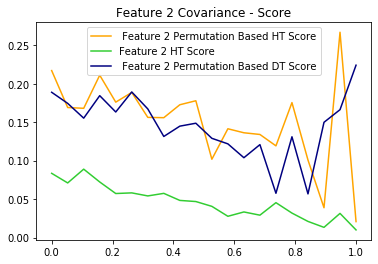

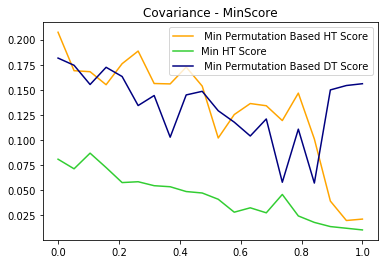

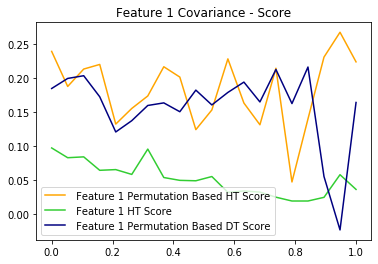

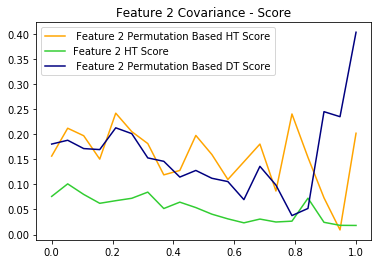

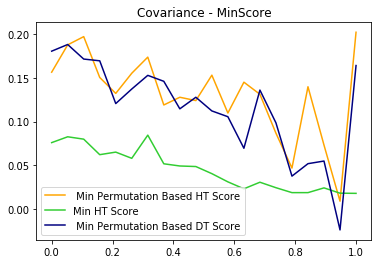

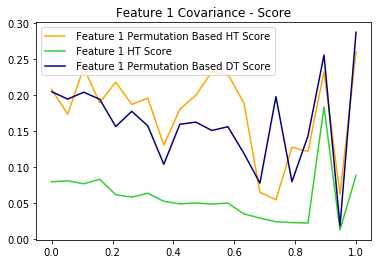

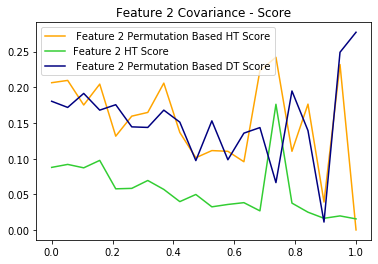

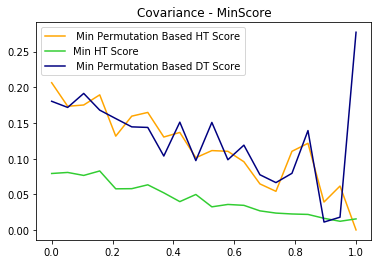

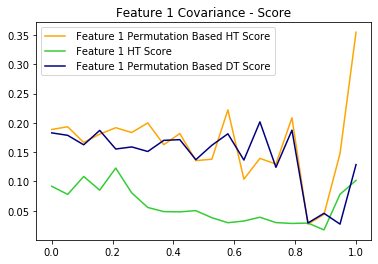

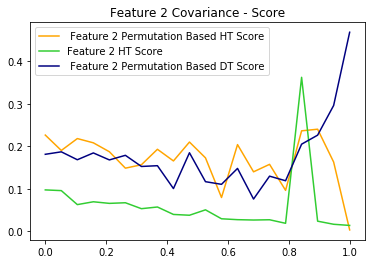

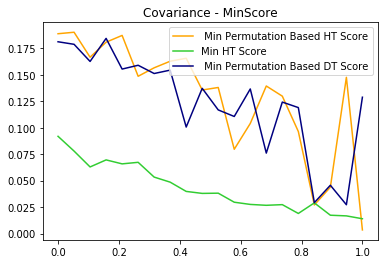

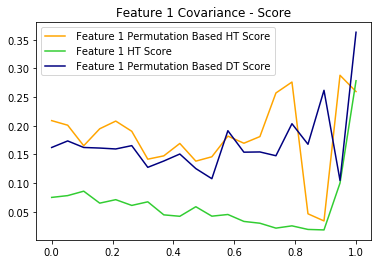

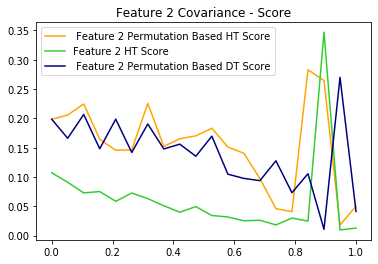

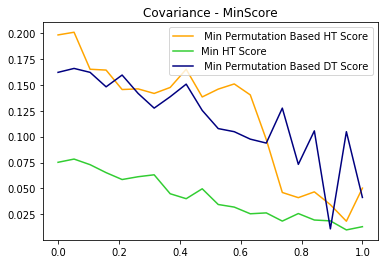

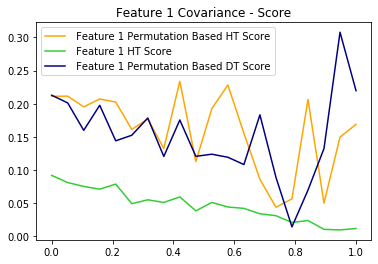

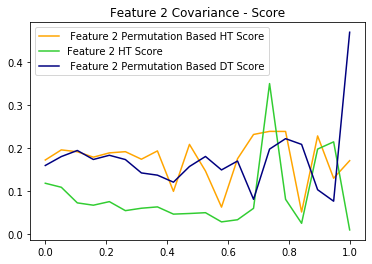

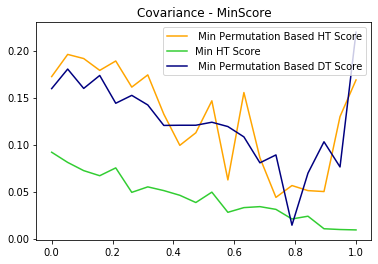

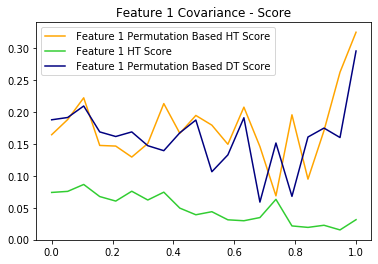

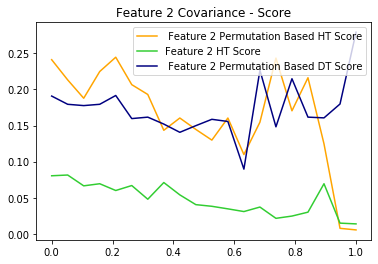

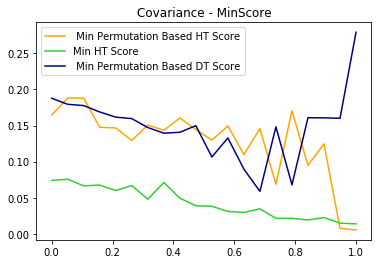

In [4]:
n1 = 3000
n2 = 3000
n_test = 500

mu_1 = [1,1]
mu_2 = [-1,-1]
cov = np.linspace(0,1,20)


#print(variance_diff_cov)
for num in range(1,10):
    mean_diff_cov = np.zeros((1,2))
    score_htp_cov = np.zeros((1,2))
    score_dt_cov = np.zeros((1,2))
    for cov_i in cov:
        Sigma = [[1,cov_i],[cov_i,1]]
        X_train = np.vstack((np.random.multivariate_normal(mu_1,Sigma ,n1),np.random.multivariate_normal(mu_2,Sigma,n2)))
        y_train = np.asarray([1]*n1 + [0]*n2)
        X_test = np.vstack((np.random.multivariate_normal(mu_1,Sigma ,n_test),np.random.multivariate_normal(mu_2,Sigma,n_test)))
        y_test = np.asarray([1]*n_test + [0]*n_test)
        
    
        clf = HonestTreeClassifier(random_state=15,honest_fraction = 0.8)
        clf = clf.fit(X_train, y_train)
    
        X_structure = X_train[clf.structure_indices_]
        X_honest = X_train[clf.honest_indices_]
        y_honest = y_train[clf.honest_indices_]
    
        leaves_indicies_before = clf.tree_.apply(X_honest.astype(np.float32))
        value_leaves_before = clf.tree_.value[leaves_indicies_before]
        classification_before = np.zeros(X_honest.shape[0])
    
        posterior_proba_before = np.zeros((X_honest.shape[0],2))##n_classes
        value_leaves = np.zeros((X_honest.shape[0],2))
        posterior_proba = np.zeros((X_honest.shape[0],2))
    
        classification_after = np.zeros(X_honest.shape[0])
        difference_clf = np.zeros(X_honest.shape[0])
    
    
    
        mean_diff = []
        for k in range(0,X_honest.shape[1]):
            for i in range(0,X_honest.shape[0]):
                ##Compute posterior probability before merging
                posterior_proba_before[i,:] = value_leaves_before[i,:]/np.sum(value_leaves_before[i,:])
                ##Compute posterior probability after merging
                value_leaves[i,:],posterior_proba[i,:] = Posterior_After(X_honest[i,:],k,50)
            #Compute the difference of posterior possibility for just one class
            ## Get the classification_before result
            classification_before[posterior_proba_before[:,0]>= 0.5] = 0
            classification_before[posterior_proba_before[:,0]< 0.5] = 1
            ## Get the classification_after result
            classification_after[posterior_proba[:,0]>= 0.5] = 0
            classification_after[posterior_proba[:,0]< 0.5] = 1
        
            #Calculate classification error before 
            error_before = np.mean(np.abs(y_honest - classification_before))
        
            #Calculate classification error after merging leaves
            error_after = np.mean(np.abs(y_honest - classification_after))
            #Calculate the difference of classification error
            difference_clf = error_after - error_before
            mean_diff = np.append(mean_diff,difference_clf)
        
        #Calculter Permutation Based HT socre
        r_htp = permutation_importance(clf, X_test, y_test,n_repeats=5,random_state=0)
        score_htp_cov = np.vstack((score_htp_cov,r_htp.importances_mean))
        
        #Calculter Permutation Based DT socre
        clf2 = DecisionTreeClassifier(random_state=15)
        clf2 = clf2.fit(X_train, y_train)
        r_dt = permutation_importance(clf2, X_test, y_test,n_repeats=5,random_state=0)
        score_dt_cov = np.vstack((score_dt_cov,r_dt.importances_mean))
        
        mean_diff_cov = np.vstack((mean_diff_cov,mean_diff))
        
    plt.plot(cov,score_htp_cov[1:,0],'orange',label = ' Feature 1 Permutation Based HT Score')
    plt.plot(cov,mean_diff_cov[1:,0],'limegreen',label = ' Feature 1 HT Score')
    plt.plot(cov,score_dt_cov[1:,0],'navy',label = ' Feature 1 Permutation Based DT Score')
    plt.title("Feature 1 Covariance - Score")
    plt.legend()
    plt.savefig("Feature 1 Covariance - Score" + str(num))
    plt.show()
    
    plt.plot(cov,score_htp_cov[1:,1],'orange',label = ' Feature 2 Permutation Based HT Score')
    plt.plot(cov,mean_diff_cov[1:,1],'limegreen',label = 'Feature 2 HT Score')
    plt.plot(cov,score_dt_cov[1:,1],'navy',label = ' Feature 2 Permutation Based DT Score')
    plt.title("Feature 2 Covariance - Score")
    plt.legend()
    plt.savefig("Feature 2 Covariance - Score" + str(num))
    plt.show()
    
    
    plt.plot(cov,np.min(score_htp_cov[1:,:],axis = 1),'orange',label = ' Min Permutation Based HT Score')
    plt.plot(cov,np.min(mean_diff_cov[1:,:],axis = 1),'limegreen',label = 'Min HT Score')
    plt.plot(cov,np.min(score_dt_cov[1:,:],axis = 1),'navy',label = ' Min Permutation Based DT Score')
    
    plt.title("Covariance - MinScore")
    plt.legend()
    plt.savefig("Covariance - MinScore" + str(num))
    plt.show()
    